In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Загрузка текстового корпуса
data = fetch_20newsgroups(subset="all")
texts = data.data
labels = data.target

# TF-IDF преобразование текста
tfidf = TfidfVectorizer(max_features=1000)
features = tfidf.fit_transform(texts).toarray()

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Перенос на GPU (если доступен)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [10]:
# Нейросеть с Dropout
class DropoutClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        return self.output(x)

# Конфигурация
input_dim = X_train.shape[1]
hidden_dim = 512
num_classes = len(np.unique(y_train))
dropout_values = [0.2, 0.4, 0.6]

In [11]:
# Обучение модели
def train(net, X, y, criterion, optimizer, epochs=50):
    net.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        predictions = net(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()

In [12]:
# Предсказания с MC Dropout
def predict_mc(net, X, passes=500):
    net.train()  # Dropout активен
    all_preds = []
    with torch.no_grad():
        for _ in range(passes):
            logits = net(X)
            pred_labels = torch.argmax(logits, dim=1)
            all_preds.append(pred_labels.cpu().numpy())
    return np.array(all_preds)

In [13]:
# Сбор результатов
metrics = {}
for p in dropout_values:
    model = DropoutClassifier(input_dim, hidden_dim, num_classes, dropout_rate=p).to(device)
    opt = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    train(model, X_train_tensor, y_train_tensor, loss_fn, opt)

    # Оценка без MC Dropout
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor)
        predicted_labels = torch.argmax(preds, dim=1).cpu().numpy()
        acc_plain = (predicted_labels == y_test).mean() * 100

    # Оценка с MC Dropout
    mc_preds = predict_mc(model, X_test_tensor, passes=500)
    voted_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=mc_preds)
    acc_mc = (voted_preds == y_test).mean() * 100

    # Неопределенность как дисперсия
    uncertainty = np.var(mc_preds, axis=0)

    metrics[p] = {
        "acc_plain": acc_plain,
        "acc_mc": acc_mc,
        "uncertainty": uncertainty
    }

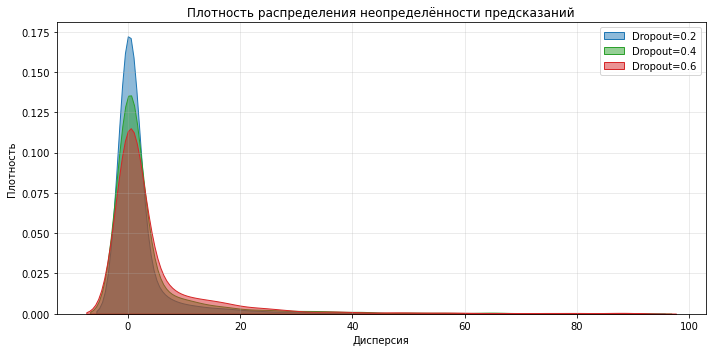

In [15]:
# Визуализация неопределённостей
palette = {0.2: "#1f77b4", 0.4: "#2ca02c", 0.6: "#d62728"}
plt.figure(figsize=(10, 5))
for d, m in metrics.items():
    sns.kdeplot(m["uncertainty"], fill=True, label=f"Dropout={d}", color=palette[d], alpha=0.5)
plt.title("Плотность распределения неопределённости предсказаний")
plt.xlabel("Дисперсия")
plt.ylabel("Плотность")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Финальный вывод
print("Результаты эксперимента с различными уровнями Dropout:\n")
for d, m in metrics.items():
    print(f"[Dropout: {d}]")
    print(f"  - Accuracy (без MC Dropout): {m['acc_plain']:.2f}%")
    print(f"  - Accuracy (с MC Dropout):   {m['acc_mc']:.2f}%")
    print(f"  - Средняя неопределенность:  {np.mean(m['uncertainty']):.4f}\n")

Результаты эксперимента с различными уровнями Dropout:

[Dropout: 0.2]
  - Accuracy (без MC Dropout): 74.46%
  - Accuracy (с MC Dropout):   74.32%
  - Средняя неопределенность:  2.9888

[Dropout: 0.4]
  - Accuracy (без MC Dropout): 74.72%
  - Accuracy (с MC Dropout):   74.88%
  - Средняя неопределенность:  4.3697

[Dropout: 0.6]
  - Accuracy (без MC Dropout): 75.86%
  - Accuracy (с MC Dropout):   75.65%
  - Средняя неопределенность:  5.4778

